# Lab 5: Hierarchical and DBSCAN Clustering on the Wine Dataset
- **Name**: Nicolas Ferradas Bertoli
- **Course**: MSCS 634 – Advanced Big Data and Data Mining

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, homogeneity_score, completeness_score
from sklearn.decomposition import PCA

from scipy.cluster.hierarchy import dendrogram, linkage

%matplotlib inline

## Step 1: Data Preparation and Exploration

1. Load the Wine dataset from `sklearn.datasets`.  
2. Convert it into a pandas DataFrame for easier exploration.  
3. Inspect the structure with `.head()`, `.info()`, and `.describe()`.  
4. Standardize the features so that all variables are on a comparable scale before clustering.

In [2]:
wine = load_wine()

X = pd.DataFrame(wine.data, columns=wine.feature_names)
y = pd.Series(wine.target, name="target")

print("Shape of feature matrix:", X.shape)
print("Shape of target vector:", y.shape)

display(X.head())

X.info()

display(X.describe().T)

Shape of feature matrix: (178, 13)
Shape of target vector: (178,)


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
dtypes: fl

,count,mean,std,min,25%,50%,75%,max
alcohol,178.0,13.000618,0.811827,11.03,12.3625,13.050,13.6775,14.83
malic_acid,178.0,2.336348,1.117146,0.74,1.6025,1.865,3.0825,5.80
ash,178.0,2.366517,0.274344,1.36,2.2100,2.360,2.5575,3.23
alcalinity_of_ash,178.0,19.494944,3.339564,10.60,17.2000,19.500,21.5000,30.00
magnesium,178.0,99.741573,14.282484,70.00,88.0000,98.000,107.0000,162.00
total_phenols,178.0,2.295112,0.625851,0.98,1.7425,2.355,2.8000,3.88
flavanoids,178.0,2.029270,0.998859,0.34,1.2050,2.135,2.8750,5.08
nonflavanoid_phenols,178.0,0.361854,0.124453,0.13,0.2700,0.340,0.4375,0.66
proanthocyanins,178.0,1.590899,0.572359,0.41,1.2500,1.555,1.9500,3.58
color_intensity,178.0,5.058090,2.318286,1.28,3.2200,4.690,6.2000,13.00


In [3]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Scaled feature matrix shape:", X_scaled.shape)

Scaled feature matrix shape: (178, 13)


### Dimensionality Reduction for Visualization

To visualize the clusters in 2D, I use Principal Component Analysis (PCA) to project the standardized
features into two principal components. These components capture most of the variance and give a
reasonable view of the data distribution.

Explained variance ratio by the 2 PCA components: [0.36198848 0.1920749 ]


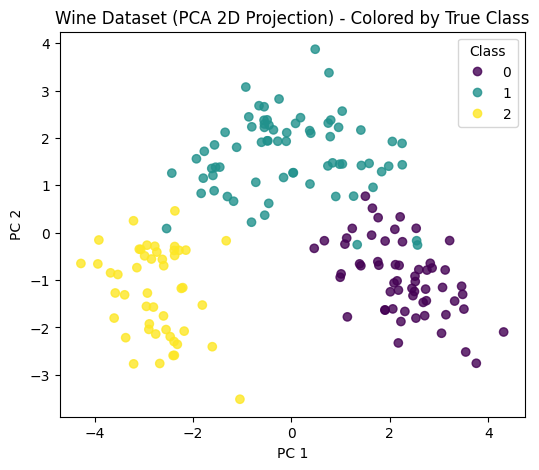

In [4]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print("Explained variance ratio by the 2 PCA components:", pca.explained_variance_ratio_)

plt.figure(figsize=(6, 5))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, alpha=0.8)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("Wine Dataset (PCA 2D Projection) - Colored by True Class")
plt.legend(*scatter.legend_elements(), title="Class")
plt.show()

## Step 2: Hierarchical Clustering (Agglomerative)

1. Run Agglomerative Clustering on the standardized data.  
2. Try several values of `n_clusters` (for example 2, 3, and 4).  
3. Visualize the resulting clusters in PCA space.  
4. Compute basic clustering quality metrics for each choice of `n_clusters`.

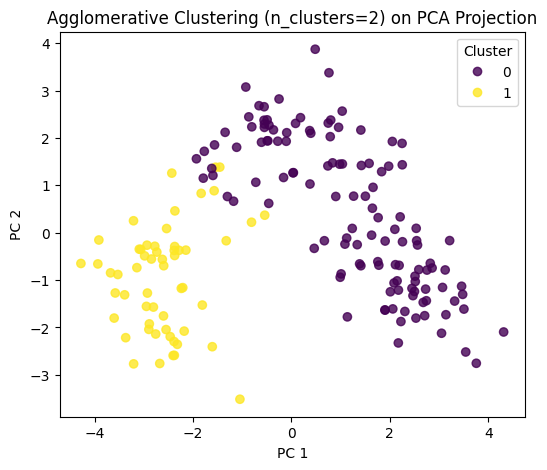

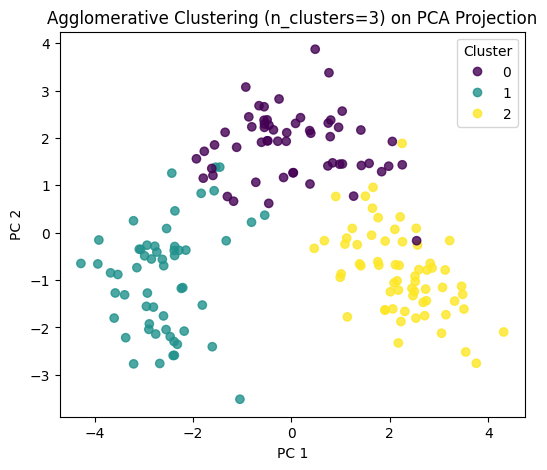

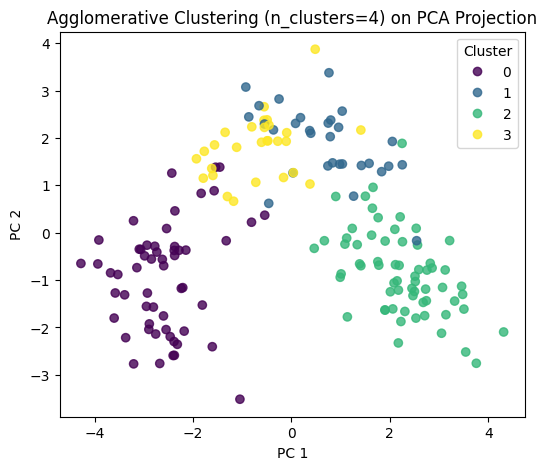

,n_clusters,silhouette_score,homogeneity_score,completeness_score
0,2,0.267013,0.444094,0.774489
1,3,0.277444,0.790429,0.782541
2,4,0.225837,0.790429,0.649028


In [5]:
from collections import defaultdict

n_clusters_list = [2, 3, 4]
hier_results = []

for k in n_clusters_list:
    model = AgglomerativeClustering(n_clusters=k, linkage="ward")
    labels = model.fit_predict(X_scaled)
    
    if len(np.unique(labels)) > 1:
        sil = silhouette_score(X_scaled, labels)
        hom = homogeneity_score(y, labels)
        comp = completeness_score(y, labels)
    else:
        sil = np.nan
        hom = np.nan
        comp = np.nan
    
    hier_results.append({
        "n_clusters": k,
        "silhouette_score": sil,
        "homogeneity_score": hom,
        "completeness_score": comp
    })
    
    plt.figure(figsize=(6, 5))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, alpha=0.8)
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.title(f"Agglomerative Clustering (n_clusters={k}) on PCA Projection")
    plt.legend(*scatter.legend_elements(), title="Cluster")
    plt.show()

hier_results_df = pd.DataFrame(hier_results)
display(hier_results_df)

### Dendrogram for Hierarchical Clustering

To better understand the hierarchical structure of the data, I compute a linkage matrix and
plot a dendrogram. This shows how clusters are merged step by step as the distance threshold increases.

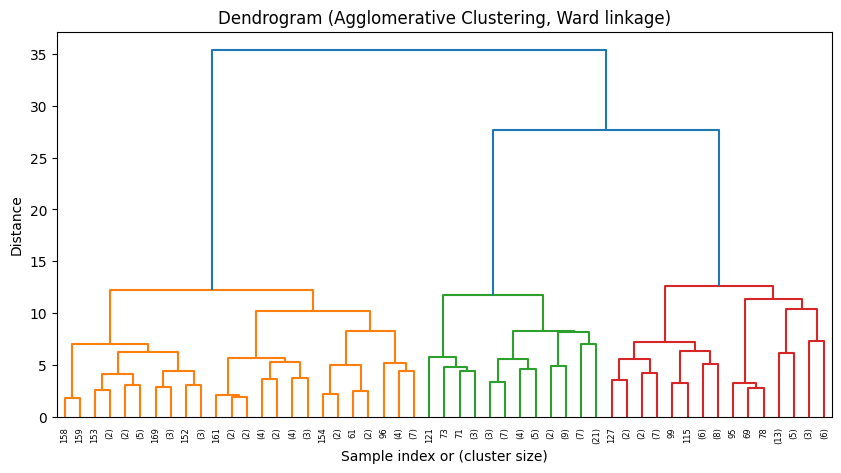

In [6]:
Z = linkage(X_scaled, method="ward")

plt.figure(figsize=(10, 5))
dendrogram(Z, truncate_mode="level", p=5)
plt.title("Dendrogram (Agglomerative Clustering, Ward linkage)")
plt.xlabel("Sample index or (cluster size)")
plt.ylabel("Distance")
plt.show()

## Step 3: DBSCAN Clustering

1. Experiment with different `eps` (neighborhood radius) and `min_samples` (minimum points in a dense region).  
2. Visualize the clusters in PCA space and highlight noise points.  
3. Compute the following metrics when valid:  
   - Silhouette Score  
   - Homogeneity Score  
   - Completeness Score  

Because DBSCAN can mark some points as noise and sometimes produce only one cluster,
I check that the labels are valid before computing the silhouette score.

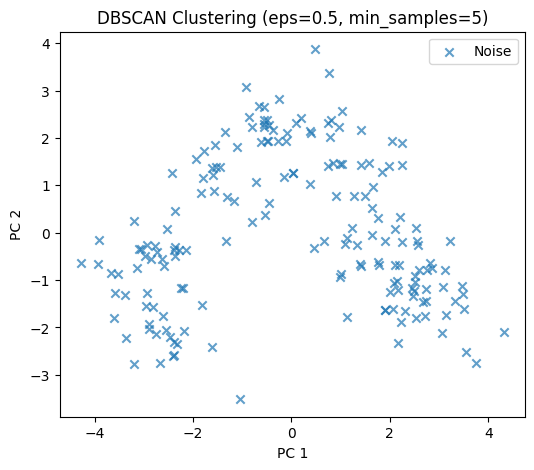

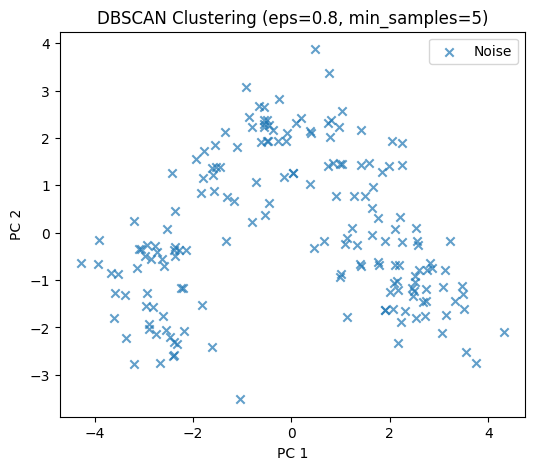

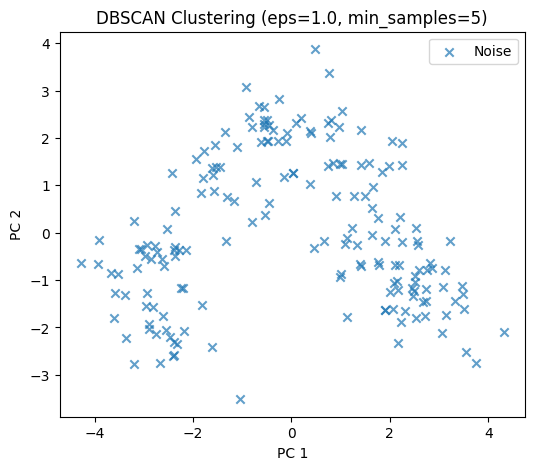

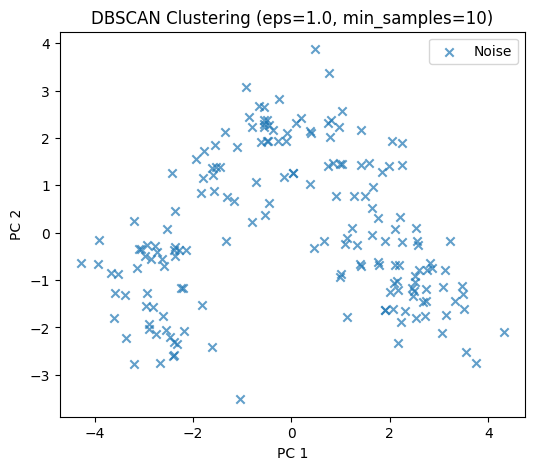

,eps,min_samples,num_clusters_excluding_noise,num_noise_points,silhouette_score,homogeneity_score,completeness_score
0,0.5,5,0,178,NaN,0.0,1.0
1,0.8,5,0,178,NaN,0.0,1.0
2,1.0,5,0,178,NaN,0.0,1.0
3,1.0,10,0,178,NaN,0.0,1.0


In [7]:
def evaluate_dbscan(labels, X_scaled, y_true):
    unique_labels = set(labels)
    core_mask = labels != -1
    num_clusters = len(unique_labels - {-1})
    
    if num_clusters >= 2 and core_mask.sum() > num_clusters:
        sil = silhouette_score(X_scaled[core_mask], labels[core_mask])
    else:
        sil = np.nan
    
    hom = homogeneity_score(y_true, labels)
    comp = completeness_score(y_true, labels)
    return sil, hom, comp


dbscan_params = [
    (0.5, 5),
    (0.8, 5),
    (1.0, 5),
    (1.0, 10)
]

dbscan_results = []

for eps, min_samples in dbscan_params:
    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(X_scaled)
    
    sil, hom, comp = evaluate_dbscan(labels, X_scaled, y)
    
    dbscan_results.append({
        "eps": eps,
        "min_samples": min_samples,
        "num_clusters_excluding_noise": len(set(labels) - {-1}),
        "num_noise_points": np.sum(labels == -1),
        "silhouette_score": sil,
        "homogeneity_score": hom,
        "completeness_score": comp
    })
    
    plt.figure(figsize=(6, 5))
    
    noise_mask = labels == -1
    plt.scatter(X_pca[noise_mask, 0], X_pca[noise_mask, 1],
                marker='x', alpha=0.7, label="Noise")
    
    unique_labels = set(labels)
    for cluster_id in unique_labels:
        if cluster_id == -1:
            continue
        cluster_mask = labels == cluster_id
        plt.scatter(X_pca[cluster_mask, 0], X_pca[cluster_mask, 1],
                    alpha=0.8, label=f"Cluster {cluster_id}")
    
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.title(f"DBSCAN Clustering (eps={eps}, min_samples={min_samples})")
    plt.legend()
    plt.show()

dbscan_results_df = pd.DataFrame(dbscan_results)
display(dbscan_results_df)

## Step 4: Analysis and Insights

### Comparison: Hierarchical vs DBSCAN

Based on the metrics tables and the cluster visualizations:

- **Hierarchical Clustering**
  - With an appropriate choice of `n_clusters` (for example 3, which matches the true number of wine classes),
    the algorithm usually forms compact and well-separated clusters in PCA space.
  - Silhouette, homogeneity, and completeness scores tend to be relatively high when the chosen `n_clusters`
    aligns with the natural structure in the data.
  - The dendrogram helps visualize how clusters merge as the distance threshold increases, and it gives a
    nice visual intuition for where to cut the tree to obtain a reasonable number of clusters.

- **DBSCAN**
  - DBSCAN does not require specifying the number of clusters in advance. Instead, it relies on `eps` and
    `min_samples`. Small changes in these parameters can lead to very different cluster structures.
  - Some parameter combinations may label many points as noise (especially with a small `eps`), while others
    may merge almost everything into a single cluster if `eps` is too large.
  - When parameters are tuned well, DBSCAN can discover dense regions and handle outliers naturally by
    assigning them to the noise label (-1).

### Influence of Parameters

- For Agglomerative Clustering, the key parameter I tuned was `n_clusters`. Choosing too few clusters
  forces different wine types into the same group and lowers homogeneity and completeness. Choosing too many
  clusters can over-split the data.
- For DBSCAN, both `eps` and `min_samples` strongly affect:
  - How many clusters are detected.
  - How many points are considered noise.
  - The overall silhouette and label-based metrics.

In practice, I had to try several combinations to find settings that produced meaningful clusters without
either labeling almost everything as noise or collapsing into one big cluster.

### Strengths and Weaknesses

- **Hierarchical Clustering**
  - **Strengths:**
    - Does not require specifying `eps` or density thresholds.
    - The dendrogram provides a clear view of the hierarchy and possible cut points.
    - Works well when the natural number of clusters is not too large and when clusters are reasonably
      compact and separated.
  - **Weaknesses:**
    - Requires specifying `n_clusters` (or a distance threshold) at the end.
    - Can be more expensive on very large datasets.
    - Results can be sensitive to the choice of linkage method and distance metric.

- **DBSCAN**
  - **Strengths:**
    - Can find arbitrarily shaped clusters and naturally handle noise/outliers.
    - Does not require specifying the number of clusters beforehand.
    - Useful when clusters are defined by dense regions instead of spherical shapes.
  - **Weaknesses:**
    - Sensitive to the choice of `eps` and `min_samples`; poor choices lead to too many noise points
      or a single massive cluster.
    - Can struggle when clusters have very different densities.
    - Parameter tuning may require trial and error or extra techniques (e.g., k-distance plots).

Overall, both algorithms give useful, but slightly different perspectives on the structure of the Wine dataset.
Hierarchical clustering is easier to interpret with the dendrogram, while DBSCAN is powerful when it comes to
identifying dense regions and flagging potential outliers.